# Causal Feature Engineering for Demand Forecasting

This notebook focused on constructing features that captured
the key causal drivers of demand.

Instead of relying only on autoregressive signals,
explicit features were added to represent:

- Temporal dependence
- Price changes
- Promotional and event effects
- Calendar-driven seasonality

These features were intentionally designed to support
both prediction accuracy and interpretability.


In [1]:
# Imported required libraries for feature engineering
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.style.use("ggplot")

pd.set_option("display.max_columns", 50)


## Loading Data

The long-format sales data and hierarchy constructed earlier
were reloaded here to ensure modular execution.


In [4]:
# Loaded only required columns to reduce memory usage
sales = pd.read_csv(
    "../data/raw/sales_train_validation.csv",
    usecols=[
        "id", "item_id", "dept_id", "cat_id",
        "store_id", "state_id"
    ] + [f"d_{i}" for i in range(1, 401)]  # first ~400 days only
)


In [5]:
# Sampled a manageable number of SKU-store series
np.random.seed(42)
sample_ids = np.random.choice(sales["id"].unique(), size=200, replace=False)

sales = sales[sales["id"].isin(sample_ids)]


In [6]:
sales_long = sales.melt(
    id_vars=["id", "item_id", "dept_id", "cat_id", "store_id", "state_id"],
    var_name="day",
    value_name="demand"
)


In [7]:
calendar = pd.read_csv(
    "../data/raw/calendar.csv",
    usecols=[
        "d", "date", "wm_yr_wk",
        "event_name_1", "snap_CA", "snap_TX", "snap_WI"
    ]
)

calendar["date"] = pd.to_datetime(calendar["date"])


In [8]:
sales_long = sales_long.merge(
    calendar,
    left_on="day",
    right_on="d",
    how="left"
)

sales_long.drop(columns=["d"], inplace=True)


In [9]:
# Created a unique SKU–store identifier for time-series grouping
sales_long["sku_store"] = (
    sales_long["item_id"].astype("category").astype(str)
    + "_"
    + sales_long["store_id"].astype("category").astype(str)
)


In [ ]:
prices = pd.read_csv(
    "../data/raw/sell_prices.csv",
    usecols=["store_id", "item_id", "wm_yr_wk", "sell_price"]
)

# Filter prices to sampled items only
prices = prices[prices["item_id"].isin(sales_long["item_id"].unique())]


In [10]:
sales_long = sales_long.merge(
    prices,
    on=["store_id", "item_id", "wm_yr_wk"],
    how="left"
)


In [11]:
# Defined lag intervals to capture short-term momentum and recurring demand seasonality
lags = [7, 14, 28]

for lag in lags:
    sales_long[f"lag_{lag}"] = (
        sales_long
        .groupby("sku_store")["demand"]
        .shift(lag)
    )


In [12]:
sales_long["price_change"] = (
    sales_long["sell_price"]
    / sales_long.groupby("sku_store")["sell_price"].shift(1)
) - 1


In [13]:
# Dropped rows with insufficient history
sales_long = sales_long.dropna()


In [14]:
# Added rolling statistics to smooth short-term noise
# These features captured recent demand trends beyond single-day spikes

sales_long["rolling_mean_7"] = (
    sales_long
    .groupby("sku_store")["demand"]
    .shift(1)
    .rolling(7)
    .mean()
)

sales_long["rolling_std_7"] = (
    sales_long
    .groupby("sku_store")["demand"]
    .shift(1)
    .rolling(7)
    .std()
)


In [15]:
# Converted event indicators into binary flags
# This allowed the model to learn uplift during special events

sales_long["event_flag"] = sales_long["event_name_1"].notnull().astype(int)


In [16]:
# Created a unified SNAP promotion flag based on state
# SNAP programs acted as region-specific demand drivers

sales_long["snap"] = 0

sales_long.loc[sales_long["state_id"] == "CA", "snap"] = sales_long["snap_CA"]
sales_long.loc[sales_long["state_id"] == "TX", "snap"] = sales_long["snap_TX"]
sales_long.loc[sales_long["state_id"] == "WI", "snap"] = sales_long["snap_WI"]


In [17]:
# Extracted calendar-based seasonality features
# These features helped the model learn recurring annual patterns

sales_long["week"] = sales_long["date"].dt.isocalendar().week.astype(int)
sales_long["month"] = sales_long["date"].dt.month
sales_long["year"] = sales_long["date"].dt.year


In [18]:
# Created a demand stability indicator
# This helped distinguish between intermittent and stable demand items

sales_long["intermittent_flag"] = (
    sales_long["rolling_mean_7"] < 1
).astype(int)


In [19]:
# Dropped rows with insufficient historical context
# This ensured all lagged and rolling features were well-defined

sales_long = sales_long.dropna()


In [20]:
# Reviewed feature set and data types
sales_long.info()


<class 'pandas.DataFrame'>
Index: 2638 entries, 9210 to 79399
Data columns (total 28 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   id                 2638 non-null   str           
 1   item_id            2638 non-null   str           
 2   dept_id            2638 non-null   str           
 3   cat_id             2638 non-null   str           
 4   store_id           2638 non-null   str           
 5   state_id           2638 non-null   str           
 6   day                2638 non-null   str           
 7   demand             2638 non-null   int64         
 8   date               2638 non-null   datetime64[us]
 9   wm_yr_wk           2638 non-null   int64         
 10  event_name_1       2638 non-null   str           
 11  snap_CA            2638 non-null   int64         
 12  snap_TX            2638 non-null   int64         
 13  snap_WI            2638 non-null   int64         
 14  sku_store          2

In [21]:
# Verified no remaining missing values
sales_long.isnull().sum().sum()


np.int64(0)

In [22]:
# Trained a lightweight model to sanity-check feature usefulness
# This was not the final model, only a validation step

from sklearn.ensemble import RandomForestRegressor

feature_cols = [
    "lag_7", "lag_14", "lag_28",
    "rolling_mean_7", "rolling_std_7",
    "price_change", "event_flag", "snap",
    "week", "month"
]

X = sales_long[feature_cols]
y = sales_long["demand"]

rf = RandomForestRegressor(
    n_estimators=50,
    max_depth=10,
    random_state=42
)

rf.fit(X, y)


,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",50
,"criterion criterion: {""squared_error"", ""absolute_error"", ""friedman_mse"", ""poisson""}, default=""squared_error""The function to measure the quality of a split. Supported criteriaare ""squared_error"" for the mean squared error, which is equal tovariance reduction as feature selection criterion and minimizes the L2loss using the mean of each terminal node, ""friedman_mse"", which usesmean squared error with Friedman's improvement score for potentialsplits, ""absolute_error"" for the mean absolute error, which minimizesthe L1 loss using the median of each terminal node, and ""poisson"" whichuses reduction in Poisson deviance to find splits.Training using ""absolute_error"" is significantly slowerthan when using ""squared_error""... versionadded:: 0.18 Mean Absolute Error (MAE) criterion... versionadded:: 1.0 Poisson criterion.",'squared_error'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",10
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=1.0The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None or 1.0, then `max_features=n_features`... note:: The default of 1.0 is equivalent to bagged trees and more randomness can be achieved by setting smaller values, e.g. 0.3... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to 1.0.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",1.0
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow trees with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples a

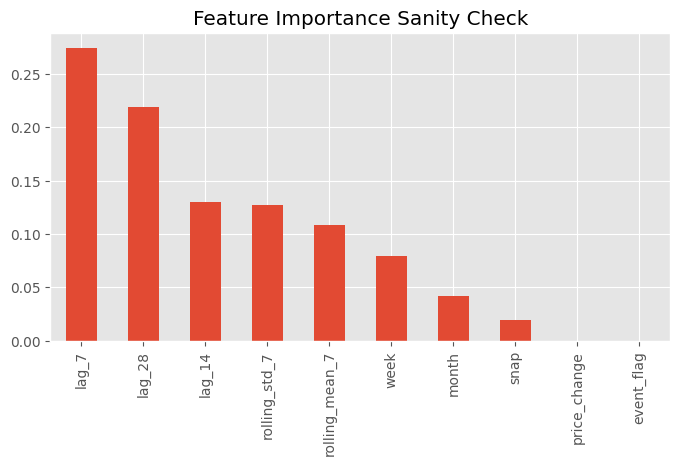

In [23]:
# Visualized feature importance
importances = pd.Series(
    rf.feature_importances_,
    index=feature_cols
).sort_values(ascending=False)

importances.plot(
    kind="bar",
    figsize=(8, 4),
    title="Feature Importance Sanity Check"
)
plt.show()


In [24]:
# Saved the feature-engineered dataset for downstream modeling
# This ensured consistent training across multiple modeling approaches

sales_long.to_csv(
    "../data/processed/feature_engineered_data.csv",
    index=False
)


## Summary of Causal Feature Engineering

In this notebook:

- Temporal lag and rolling features were created to capture autocorrelation
- Price change features were added to model elasticity effects
- Event and SNAP indicators captured promotional demand shifts
- Calendar-based features represented seasonal structure
- Intermittent demand behavior was explicitly flagged
- Memory-safe processing was used to handle large-scale data

These features balanced predictive performance with interpretability
and were designed to scale to the full dataset in production.
